In [1]:
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy import signal
import shutil
from sklearn.decomposition import FastICA
op = os.path
%matplotlib inline

In [2]:
ROOT = 'recordings/wav'
fnames = [op.join(ROOT, f) for f in os.listdir(ROOT)]

In [3]:
data = [wavfile.read(f) for f in fnames]
FS = set([d[0] for d in data]).pop()
FS

22050

In [4]:
data = [d[1] for d in data]
data = [c for c in data if c.shape[0] < 200 * FS]
data = [c for c in data if c.shape[0] > 50 * FS]

In [5]:
N = FS * 50
N

1102500

In [6]:
X = np.zeros((N, 100), dtype=np.int16)
for i, c in enumerate(data):
    X[:, i] = c[:N]

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

In [8]:
low = 200
high= 3500

XFILT = np.zeros(X.shape)
for i in range(100):
    XFILT[:, i] = butter_bandpass_filter(X[:, i], low, high, FS, 6)

In [9]:
ica = FastICA(n_components=100)
xred = ica.fit_transform(XFILT)

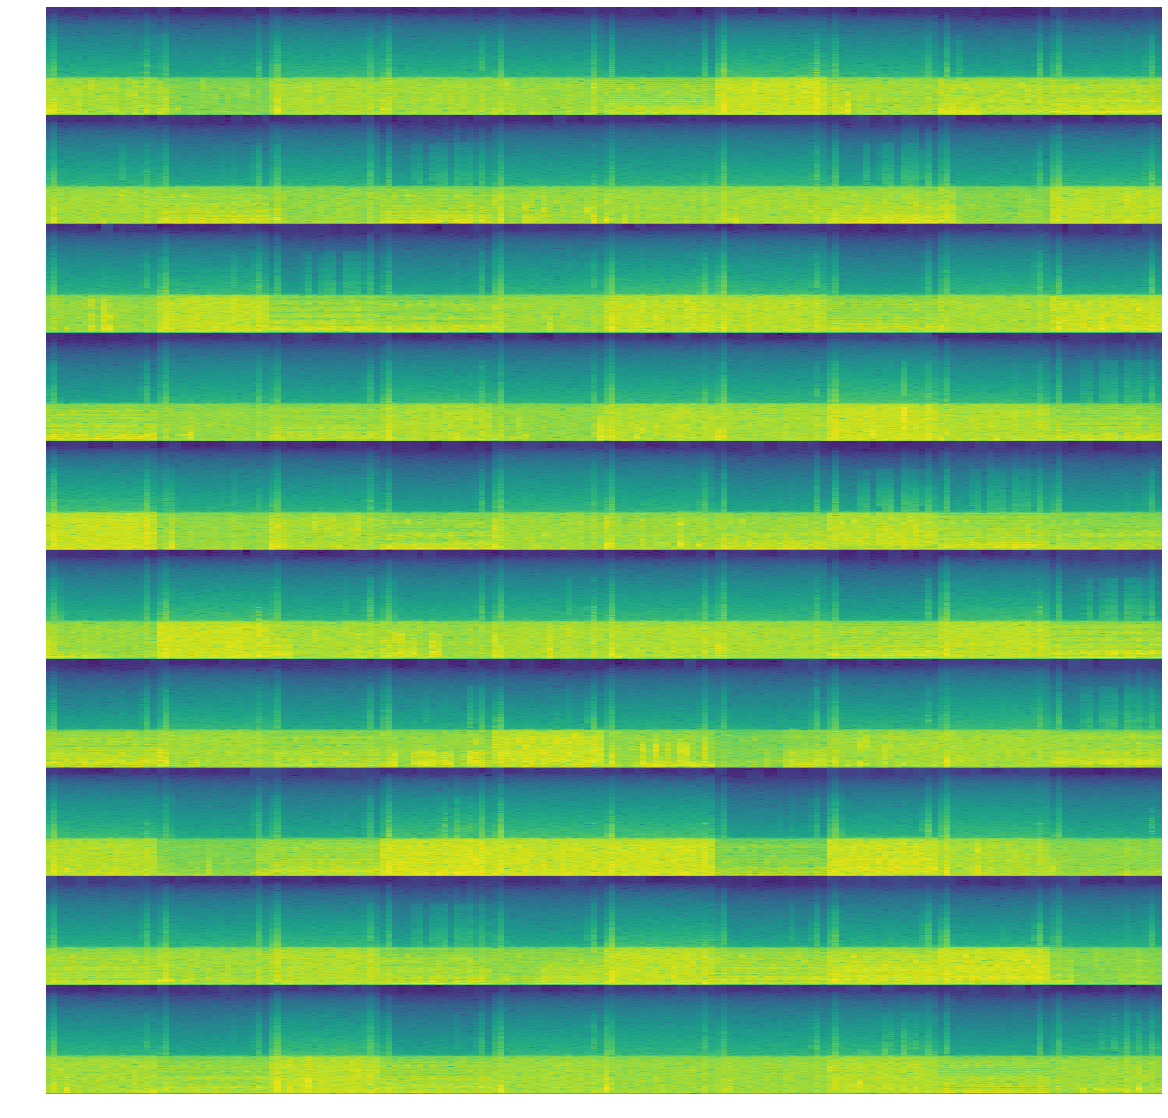

In [10]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(10):
    for j in range(10):
        x = xred[:, i * 10 + j]
        f, t, SXX = signal.spectrogram(x, FS, nperseg= 2 ** 16)
        ax[i, j].pcolormesh(t, f, np.log(SXX))
        ax[i, j].set_axis_off()

In [11]:
!mkdir filtered

In [14]:
wavfile.write?

Signature: wavfile.write(filename, rate, data)
Docstring:
Write a numpy array as a WAV file.

Parameters
----------
filename : string or open file handle
    Output wav file.
rate : int
    The sample rate (in samples/sec).
data : ndarray
    A 1-D or 2-D numpy array of either integer or float data-type.

Notes
-----
* Writes a simple uncompressed WAV file.
* To write multiple-channels, use a 2-D array of shape
  (Nsamples, Nchannels).
* The bits-per-sample and PCM/float will be determined by the data-type.

Common data types: [1]_

=====================  ===========  ===========  =============
     WAV format            Min          Max       NumPy dtype
=====================  ===========  ===========  =============
32-bit floating-point  -1.0         +1.0         float32
32-bit PCM             -2147483648  +2147483647  int32
16-bit PCM             -32768       +32767       int16
8-bit PCM              0            255          uint8
=====================  ===========  ===========  ==

In [13]:
from tqdm import tqdm 

In [15]:
for i in tqdm(range(100)):
    wavfile.write(f'filtered/{i+1}.wav', FS, xred[:, i])

100%|██████████| 100/100 [00:01<00:00, 52.61it/s]


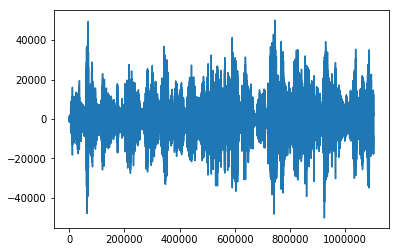

In [26]:
plt.plot(XFILT[:,  0] - XFILT[:, 1])

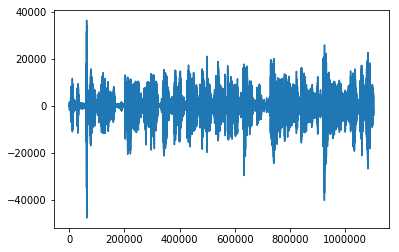

In [27]:
plt.plot(XFILT[:, 0])

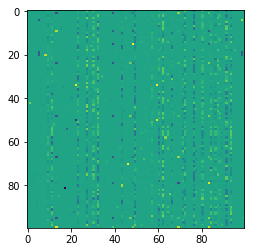

In [24]:
plt.imshow(ica.mixing_)

In [20]:
from joblib import dump, load

In [21]:
dump(ica, 'ica_master.pkl')

['ica_master.pkl']

In [22]:
xx = load('ica_master.pkl')

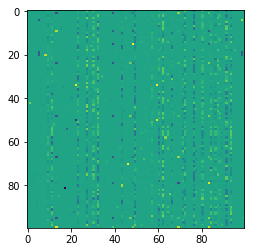

In [25]:
plt.imshow(xx.mixing_)

In [28]:
x = XFILT[:, 0]

In [29]:
x

array([    0.        ,     0.        ,     0.        , ...,
       -1626.04891415, -2149.90687098, -2709.85788158])

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
scaler = MinMaxScaler((0,  255))

In [46]:
xquant = scaler.fit_transform(xred)

In [47]:
xquant.min()

0.0

In [48]:
xquant.max()

255.00000000000006

In [49]:
xquant

array([[125.84660236, 130.58800282, 125.80090416, ..., 125.79794678,
        129.37750013, 130.51760712],
       [125.84661617, 130.58799169, 125.80090515, ..., 125.79794663,
        129.37749734, 130.5176066 ],
       [125.84671462, 130.58791232, 125.80091231, ..., 125.79794552,
        129.37747752, 130.51760292],
       ...,
       [125.48495507, 129.86723104, 125.687625  , ..., 126.11045667,
        121.2745062 , 129.06543145],
       [125.07260765, 129.90785779, 126.04534908, ..., 125.35267896,
        123.22383545, 128.68939247],
       [124.96950473, 130.17742885, 126.21151619, ..., 124.28469412,
        124.79905199, 129.07568937]])

In [50]:
XOUT = np.around(xquant).astype(np.uint8)

In [51]:
for i in tqdm(range(100)):
    wavfile.write(f'filtered/{i+1}.wav', FS, XOUT[:, i])

100%|██████████| 100/100 [00:00<00:00, 128.05it/s]
